In [24]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.dates as mdates
from scipy.stats import mannwhitneyu
from scipy.stats import kruskal


In [13]:
####Filtrage rorqual
df = pd.read_csv('/nfs/NAS7/SABIOD/SITE/SEGLVIK/manip_Justine/YOLO/YOLO_rorqual/train_final/YOLO_detection_rorqual_20241031.csv')
df['file'] = df['file'].str.split('.flac').str[0]+'.flac'
df['datetime'] = df['file'].str.extract(r'(\d{8}_\d{6})')
df['datetime'] = pd.to_datetime(df.datetime, format = '%Y%m%d_%H%M%S')
df_filtre = df[df['conf'] >=0.3]
df_filtre = df_filtre[~((df_filtre['class']==0) & (df_filtre['Low Freq (Hz)'] <6) & (df_filtre['High Freq (Hz)'] > 18))]
df_filtre = df_filtre[~((df_filtre['class']==1) & (df_filtre['Low Freq (Hz)'] <112) & (df_filtre['High Freq (Hz)'] > 122))]
count_rorqual = df_filtre.groupby(df_filtre['file']).size().reset_index(name='cet_count')
count_rorqual['datetime'] = pd.to_datetime(count_rorqual['file'].str.extract(r'(\d{8}_\d{6})')[0],format='%Y%m%d_%H%M%S')
count_rorqual = count_rorqual[(count_rorqual['file'].str.startswith('Fjord') & (count_rorqual['cet_count'] > 3)) | (count_rorqual['file'].str.startswith('ValabFr') & (count_rorqual['cet_count'] > 6))]
count_rorqual['date'] = count_rorqual['datetime'].dt.floor('D')
count_rorqual['hour'] = count_rorqual['datetime'].dt.strftime('%H:%M')
count_rorqual.to_csv('/nfs/NAS7/SABIOD/SITE/SEGLVIK/manip_Justine/YOLO/YOLO_rorqual/train_final/rorqual_yolo_detection_filtered.csv', index = False)

In [6]:
#####Filtrage baleines à bosse
df = pd.read_csv('/nfs/NAS7/SABIOD/SITE/SEGLVIK/manip_Justine/YOLO/YOLO_bosse/train_final/detection/YOLO_detection_final.csv')
df['Delta Freq (Hz)'] = df['High Freq (Hz)'] - df['Low Freq (Hz)']
df['datetime'] = df['file'].str.extract(r'(\d{8}_\d{6})')
df['datetime'] = pd.to_datetime(df.datetime, format = '%Y%m%d_%H%M%S')
df_filtre = df[df['conf'] >=0.70]
df_filtre = df_filtre[df_filtre['High Freq (Hz)'] <=18000]
df_filtre = df_filtre[df_filtre['Delta Freq (Hz)'] <=17000]
count_bosse = df_filtre.groupby(df_filtre['file']).size().reset_index(name='cet_count')
count_bosse['datetime'] =count_bosse['file'].str.extract(r'(\d{8}_\d{6})')
count_bosse['datetime'] = pd.to_datetime(count_bosse['datetime'], format = '%Y%m%d_%H%M%S')
count_bosse = count_bosse[(count_bosse['file'].str.startswith('Fjord') & (count_bosse['cet_count'] > 3)) | (count_bosse['file'].str.startswith('ValabFr') & (count_bosse['cet_count'] > 6))]
count_bosse['date'] = count_bosse['datetime'].dt.floor('D')
count_bosse['hour'] = count_bosse['datetime'].dt.strftime('%H:%M')
count_bosse.to_csv('/nfs/NAS7/SABIOD/SITE/SEGLVIK/manip_Justine/YOLO/YOLO_bosse/train_final/detection/bosse_yolo_detection_filtered.csv', index = False)

In [3]:
#####normalize by number of record
#fichiers de 2min jusqu'au 14 novembre 16h puis 5min, tout les Fjord** font 2 min, les Valab* font 5min
# ici, temps total d'enregistrement en minute par jour, heure de chaque jour, et heure sur toute la période
file_list = pd.read_csv('/nfs/NAS7/SABIOD/SITE/SEGLVIK/manip_Justine/file_list_recording_period.csv')
file_list['datetime'] = pd.to_datetime(file_list['datetime'], format = '%Y-%m-%d %H:%M:%S')
file_list['hour'] = file_list['datetime'].dt.strftime('%H:00')
file_list['date'] = file_list['datetime'].dt.floor('D')

#conversion nombre enregistrements en temps enregistrement (minute)
file_list['duration(min)'] = 5
file_list.loc[file_list['file'].str.startswith('Fjord'), 'duration(min)'] = 2
record_day = file_list.groupby(file_list['datetime'].dt.date)['duration(min)'].sum().reset_index(name='nb_record_jour').assign(datetime=lambda x: pd.to_datetime(x['datetime'])) #temps enregistrement par jour
record_day_hour = file_list.groupby(file_list['datetime'].dt.floor('H'))['duration(min)'].sum().reset_index(name='nb_record_hour/jour').assign(datetime=lambda x: pd.to_datetime(x['datetime'])) #temps enregistrement pour chaque heure/chaque jour
record_hour = file_list.groupby(file_list['hour'])['duration(min)'].sum().reset_index(name='nb_record_hour') #temps enregistrement par heure (2mois cumulés)

In [4]:
df_count = pd.read_csv('/nfs/NAS7/SABIOD/SITE/SEGLVIK/manip_Justine/YOLO/YOLO_bosse/train_final/detection/bosse_yolo_detection_filtered.csv')
df_count['datetime'] = pd.to_datetime(df_count.datetime, format = '%Y-%m-%d %H:%M:%S')
precision = 0.85
recall = 0.65

In [4]:
df_count = pd.read_csv('/nfs/NAS7/SABIOD/SITE/SEGLVIK/manip_Justine/YOLO/YOLO_rorqual/train_final/rorqual_yolo_detection_filtered.csv')
df_count['datetime'] = pd.to_datetime(df_count.datetime, format = '%Y-%m-%d %H:%M:%S')
precision = 0.90
recall = 0.78

In [20]:
###### presence/jour 
#le nombre de detection est normalisé par le nombre d'heure d'enregistrement pour chaque jour 
sum_day = df_count.groupby(df_count['datetime'].dt.floor('D'))['cet_count'].sum().reset_index(name='day_count')
sum_day = pd.merge(record_day, sum_day, on = 'datetime', how='left')
sum_day['detec_norm'] = sum_day['day_count']/(sum_day['nb_record_jour']/60)
sum_day['detec_prop'] = sum_day['day_count']/(sum_day['day_count'].sum())


(Text(0.5, 0, 'date'), Text(0, 0.5, 'mean number of detection per hour'))

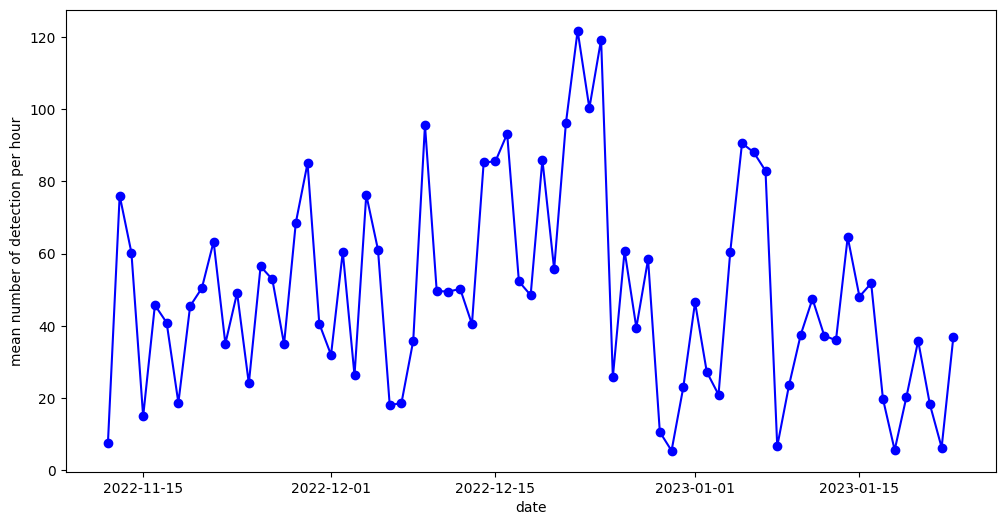

In [17]:
#graphe presence/jour
plt.figure(figsize=(12,6))
plt.plot(sum_day['datetime'], sum_day['detec_norm'], marker='o', linestyle='-', color='b')
plt.xlabel('date'), plt.ylabel('mean number of detection per hour')

In [9]:
###### presence/heure chaque jour sur la période d'enregistrement
#le nombre de detection est normalisé par le nombre de minute d'enregistrement pour chaque heure
sum_day_hour = df_count.groupby(df_count['datetime'].dt.floor('h'))['cet_count'].sum().reset_index(name='day_hour_count') 
sum_day_hour = pd.merge(record_day_hour, sum_day_hour, on = 'datetime', how='left') #merge obligatoire pour avoir les moments sans détection
sum_day_hour['detec_norm'] = sum_day_hour['day_hour_count']/sum_day_hour['nb_record_hour/jour'] #nombre de detection moyen normalisé par le nombre de minute de record
sum_day_hour['detec_norm'] = sum_day_hour['detec_norm'].fillna(0)
sum_day_hour['detec_prop'] = sum_day_hour['day_hour_count']/(sum_day_hour['day_hour_count'].sum())

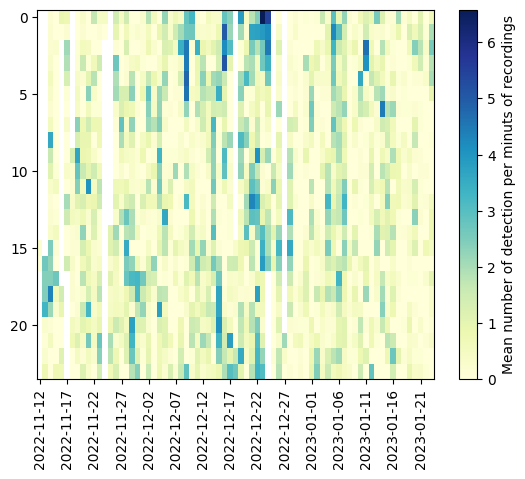

In [10]:
#graphe presence heure/jour
matrix_data = sum_day_hour.pivot_table(
    values='detec_norm',  # Valeur à afficher
    index=sum_day_hour['datetime'].dt.hour,  # Lignes : heures
    columns=sum_day_hour['datetime'].dt.floor('D')  # Colonnes : jours
)
plt.imshow(matrix_data, aspect='auto', cmap='YlGnBu')

dates = matrix_data.columns

# Définir les ticks pour l'axe x avec un intervalle de 1 (vous pouvez ajuster cela)
tick_positions = np.arange(0, len(dates), 5)

# Vérifier que nous avons des positions de ticks valides
if len(tick_positions) > 0:
    plt.gca().set_xticks(tick_positions)
    plt.gca().set_xticklabels([dates[i].strftime('%Y-%m-%d') for i in tick_positions], rotation=90)
plt.colorbar(label='Mean number of detection per minuts of recordings')



In [29]:
###### presence/heure
#le nombre de detection est normalisé par le nombre d'heure d'enregistrement pour chaque heure
sum_hour = df_count.groupby(df_count['datetime'].dt.hour)['cet_count'].sum().reset_index(name='hour_count') 
sum_hour['hour']=pd.to_datetime(sum_hour['datetime'], format = '%H').dt.strftime('%H:%M')
sum_hour = pd.merge(record_hour, sum_hour, on = 'hour', how='left')
sum_hour['detec_norm'] = sum_hour['hour_count']/(sum_hour['nb_record_hour']/60) #nombre moyen de vocalise par unité de temps (heure) pour chaque heure de la journée
sum_hour['precision_error']= sum_hour['detec_norm']*(1-precision)
sum_hour['recall_error']= sum_hour['detec_norm']*(1-recall)
sum_hour['detec_prop'] = sum_hour['hour_count']/(sum_hour['hour_count'].sum())


(Text(0.5, 0, 'date'), Text(0, 0.5, 'mean number of detection per hour'))

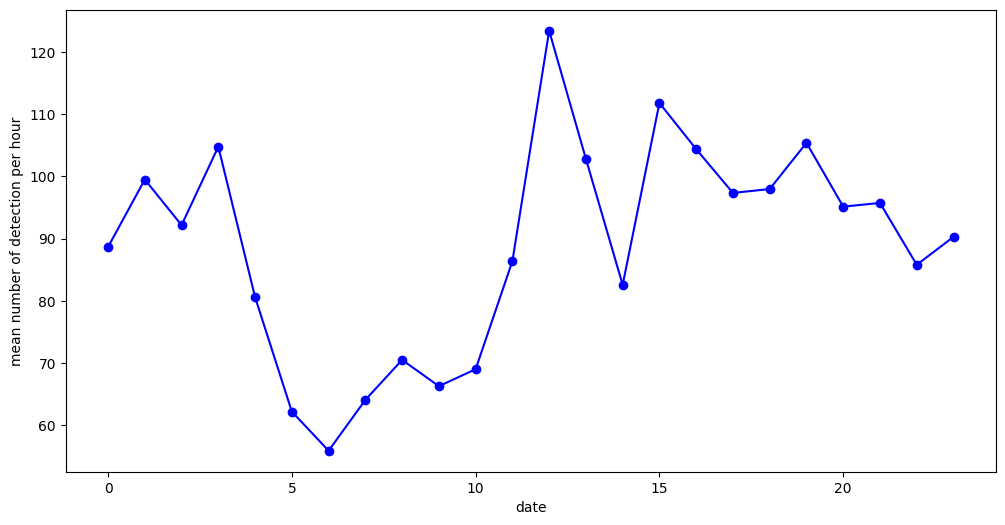

In [30]:
#graphe presence/heure
plt.figure(figsize=(12,6))
plt.plot(sum_hour['datetime'], sum_hour['detec_norm'], marker='o', linestyle='-', color='b')
plt.xlabel('date'), plt.ylabel('mean number of detection per hour')

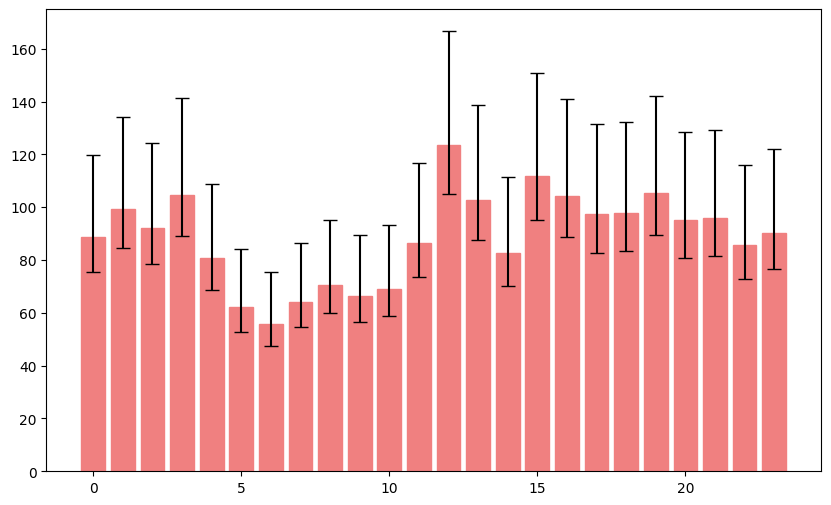

In [23]:
plt.figure(figsize=(10, 6))
yerr = [sum_hour['precision_error'], sum_hour['recall_error']]

bars = plt.bar(sum_hour['datetime'], sum_hour['detec_norm'], color='lightblue', 
                yerr=yerr, capsize=5)
for bar in bars:
    bar.set_color('lightblue' if bar.get_height() > 300 else 'lightcoral')


In [ ]:
##### chargement data solaires
solar = pd.read_csv('/nfs/NAS7/SABIOD/SITE/SEGLVIK/manip_Justine/light_data/sun_data_2022_2023.csv', sep=None)
solar['date'] = pd.to_datetime(solar.date, format = '%Y-%m-%d')
columns_to_convert = ['nautical_end', 'civil_beg', 'civil_end', 'sun_beg', 'sun_end', 'astronomical_beg', 'astronomical_end']
for col in columns_to_convert: 
    solar[col] = pd.to_datetime(solar[col], format='%H:%M').dt.strftime('%H:%M')

detec_solar = pd.merge(file_list, solar, on = 'date', how = 'left')
detec_solar = pd.merge(detec_solar, df_count[['file', 'cet_count']], on = 'file', how = 'left')
detec_solar['cet_count'] = detec_solar['cet_count'].fillna(0)
detec_solar['light_state'] = detec_solar.apply(lambda row: 'light' if row['datetime'].time() > pd.to_datetime(row['civil_beg']).time() and row['datetime'].time() < pd.to_datetime(row['civil_end']).time() 
                                               else ('dusk' if row['datetime'].time() > pd.to_datetime(row['nautical_beg']).time() and row['datetime'].time() < pd.to_datetime(row['civil_beg']).time()
                                                     else ('down' if row['datetime'].time() > pd.to_datetime(row['civil_end']).time() and row['datetime'].time() < pd.to_datetime(row['nautical_end']).time() else 'dark')), axis=1)
detec_solar['day_state'] = detec_solar.apply(lambda row: 'night' if pd.isna(row['sun_beg']) or pd.isna(row['sun_end']) else ('day' if row['datetime'].time() > pd.to_datetime(row['sun_beg'], format='%H:%M').time() and row['datetime'].time() < pd.to_datetime(row['sun_end'], format='%H:%M').time() else 'night'), axis=1)



/tmp/ipykernel_1551236/1123622059.py:2: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support sep=None with delim_whitespace=False; you can avoid this warning by specifying engine='python'.
  solar = pd.read_csv('/nfs/NAS7/SABIOD/SITE/SEGLVIK/manip_Justine/light_data/sun_data_2022_2023.csv', sep=None)


90.75572059413891 90.76038214076819 67.25791287997494 89.05752010927303
Statistique de test : 60.36264565225177
Valeur p : 4.917746904024796e-13


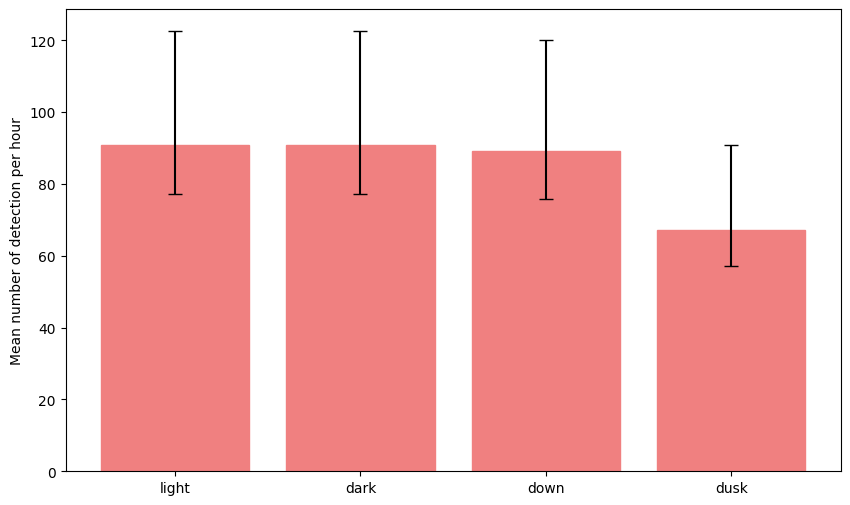

In [27]:
#stat light_state
#somme des detections divisé par le nombre d'heure d'enregistrements pour chaque catégorie
detec_solar['precision_error']= detec_solar['cet_count']*(1-precision)
detec_solar['recall_error']= detec_solar['cet_count']*(1-recall)
mean_light = detec_solar[detec_solar['light_state'] == 'light']['cet_count'].sum()/(detec_solar[detec_solar['light_state'] == 'light']['duration(min)'].sum()/60)
mean_dark= detec_solar[detec_solar['light_state'] == 'dark']['cet_count'].sum()/(detec_solar[detec_solar['light_state'] == 'dark']['duration(min)'].sum()/60)
mean_dusk= detec_solar[detec_solar['light_state'] == 'dusk']['cet_count'].sum()/(detec_solar[detec_solar['light_state'] == 'dusk']['duration(min)'].sum()/60)
mean_down= detec_solar[detec_solar['light_state'] == 'down']['cet_count'].sum()/(detec_solar[detec_solar['light_state'] == 'down']['duration(min)'].sum()/60)


#calcul de l'écart type
std_light = detec_solar[detec_solar['light_state'] == 'light'].groupby(detec_solar['datetime'].dt.floor('h'))['cet_count'].sum().std()
std_dark = detec_solar[detec_solar['light_state'] == 'dark'].groupby(detec_solar['datetime'].dt.floor('h'))['cet_count'].sum().std()
std_dusk = detec_solar[detec_solar['light_state'] == 'dusk'].groupby(detec_solar['datetime'].dt.floor('h'))['cet_count'].sum().std()
std_down = detec_solar[detec_solar['light_state'] == 'down'].groupby(detec_solar['datetime'].dt.floor('h'))['cet_count'].sum().std()


#calcul de l'erreur type
error_light = std_light/(detec_solar[detec_solar['light_state'] == 'light']['duration(min)'].sum()/60)**0.5
error_dark = std_dark/(detec_solar[detec_solar['light_state'] == 'dark']['duration(min)'].sum()/60)**0.5
error_dusk = std_dusk/(detec_solar[detec_solar['light_state'] == 'dusk']['duration(min)'].sum()/60)**0.5
error_down = std_down/(detec_solar[detec_solar['light_state'] == 'down']['duration(min)'].sum()/60)**0.5

#calcul de la variance
var_light = detec_solar[detec_solar['light_state'] == 'light']['cet_count'].var()
var_dark = detec_solar[detec_solar['light_state'] == 'dark']['cet_count'].var()
var_down = detec_solar[detec_solar['light_state'] == 'down']['cet_count'].var()
var_dusk = detec_solar[detec_solar['light_state'] == 'dusk']['cet_count'].var()

data = {'light_state':['light', 'dark', 'down', 'dusk'], 'mean': [mean_light, mean_dark, mean_down, mean_dusk], 'std':[std_light, std_dark, std_dusk, std_down], 'error':[error_light, error_dark, error_down, error_dusk], 'variance':[var_light, var_dark, var_down, var_dusk]}
df_stat = pd.DataFrame(data)
df_stat['precision_error']= df_stat['mean']*(1-precision)
df_stat['recall_error']= df_stat['mean']*(1-recall)

print(mean_light, mean_dark, mean_dusk, mean_down)

plt.figure(figsize=(10, 6))
yerr = [df_stat['precision_error'], df_stat['recall_error']]

bars = plt.bar(df_stat['light_state'], df_stat['mean'], color='lightblue', 
                yerr=yerr, capsize=5)
for bar in bars:
    bar.set_color('lightblue' if bar.get_height() > 300 else 'lightcoral')

plt.ylabel('Mean number of detection per hour')

stat, p_value = kruskal(detec_solar[detec_solar['light_state'] == 'light']['cet_count'], detec_solar[detec_solar['light_state'] == 'dark']['cet_count'], detec_solar[detec_solar['light_state'] == 'down']['cet_count'], detec_solar[detec_solar['light_state'] == 'dusk']['cet_count'])
# Affichage des résultats
print(f"Statistique de test : {stat}")
print(f"Valeur p : {p_value}")

34.72196041470311 90.30121852152722 84.05557973573349 208.8022459448296
Statistique de test : 3785028.5
Valeur p : 3.448756271113076e-19


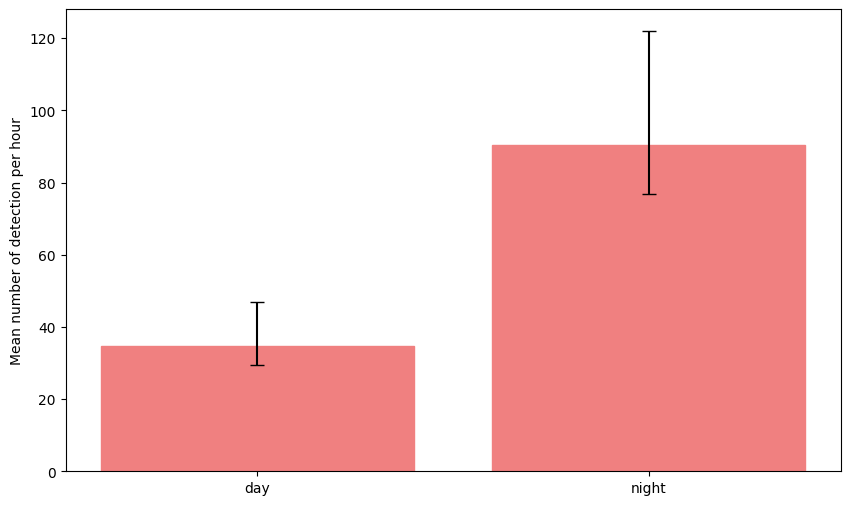

In [28]:
#stat day_state
#somme des detections divisé par le nombre d'heure d'enregistrements pour chaque catégorie
mean_day = detec_solar[detec_solar['day_state'] == 'day']['cet_count'].sum()/(detec_solar[detec_solar['day_state'] == 'day']['duration(min)'].sum()/60)
mean_night = detec_solar[detec_solar['day_state'] == 'night']['cet_count'].sum()/(detec_solar[detec_solar['day_state'] == 'night']['duration(min)'].sum()/60)

#calcul de l'écart type
std_day = detec_solar[detec_solar['day_state'] == 'day'].groupby(detec_solar['datetime'].dt.floor('h'))['cet_count'].sum().std()
std_night = detec_solar[detec_solar['day_state'] == 'night'].groupby(detec_solar['datetime'].dt.floor('h'))['cet_count'].sum().std()

#calcul de l'erreur type
error_day = std_day/(detec_solar[detec_solar['day_state'] == 'day']['duration(min)'].sum()/60)**0.5
error_night = std_day/(detec_solar[detec_solar['day_state'] == 'night']['duration(min)'].sum()/60)**0.5

#calcul de la variance
var_day = detec_solar[detec_solar['day_state'] == 'day']['cet_count'].var()
var_night = detec_solar[detec_solar['day_state'] == 'night']['cet_count'].var()

data = {'day_state':['day', 'night'], 'mean': [mean_day, mean_night], 'std':[std_day, std_night], 'error':[error_day, error_night], 'variance':[var_day, var_night]}
df_stat = pd.DataFrame(data)
df_stat['precision_error']= df_stat['mean']*(1-precision)
df_stat['recall_error']= df_stat['mean']*(1-recall)

print(mean_day, mean_night, var_day, var_night)

plt.figure(figsize=(10, 6))
yerr = [df_stat['precision_error'], df_stat['recall_error']]

bars = plt.bar(df_stat['day_state'], df_stat['mean'], color='lightblue', 
                yerr=yerr, capsize=5)
for bar in bars:
    bar.set_color('lightblue' if bar.get_height() > 300 else 'lightcoral')

plt.ylabel('Mean number of detection per hour')

stat, p_value = mannwhitneyu(detec_solar[detec_solar['day_state'] == 'day']['cet_count'], detec_solar[detec_solar['day_state'] == 'night']['cet_count'])
# Affichage des résultats
print(f"Statistique de test : {stat}")
print(f"Valeur p : {p_value}")